# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/adragneel/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 67 (delta 6), reused 3 (delta 3), pack-reused 54 (from 2)
Receiving objects: 100% (67/67), 1.88 MiB | 4.27 MiB/s, done.
Resolving deltas: 100% (19/19), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


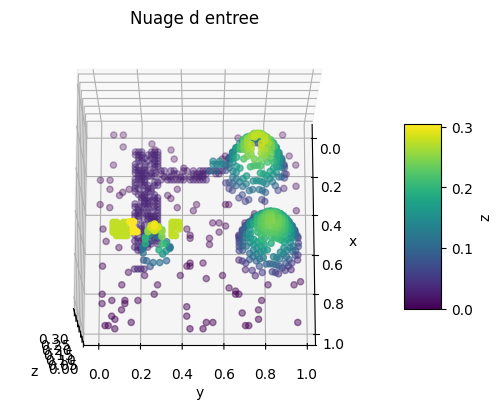

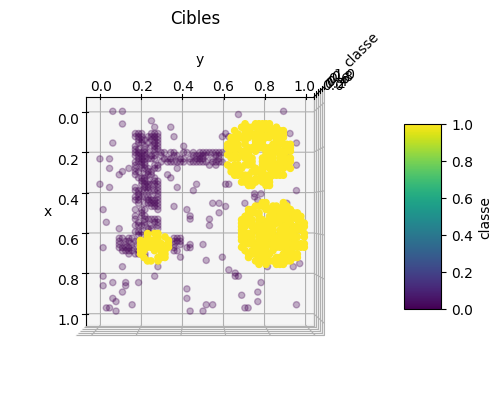

1


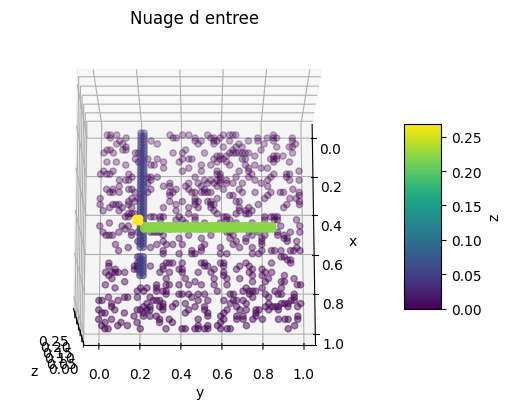

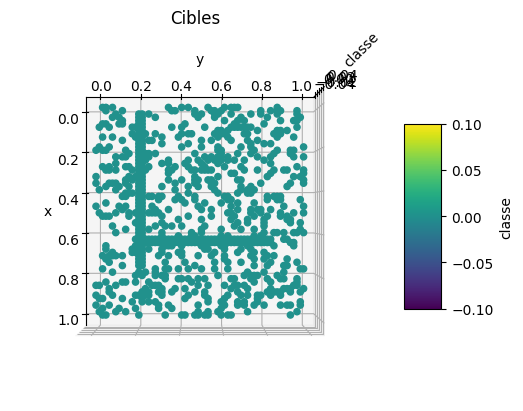

2


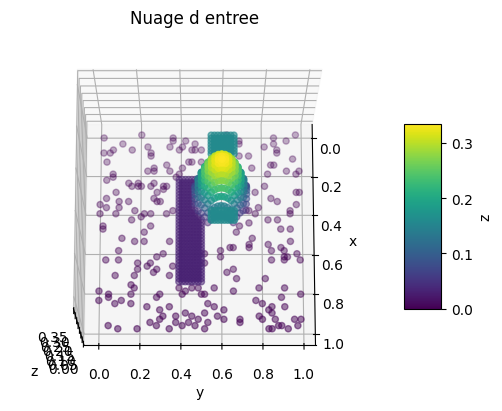

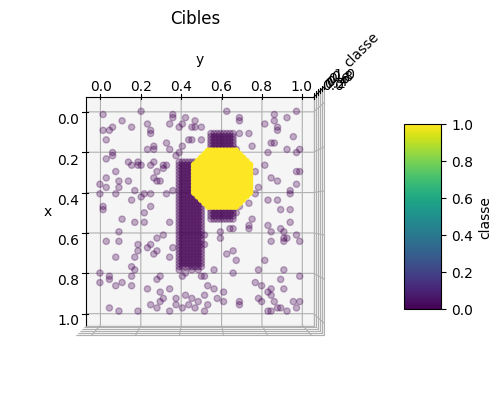

3


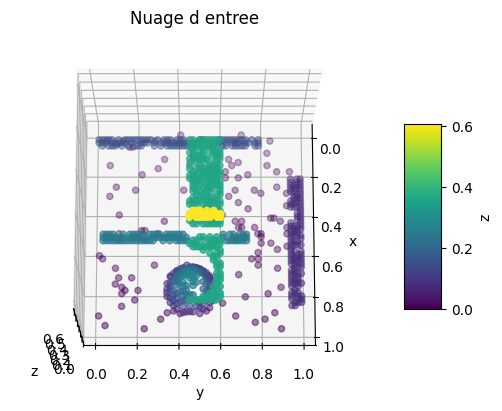

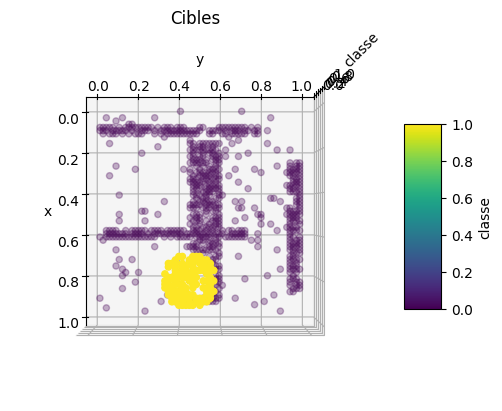

4


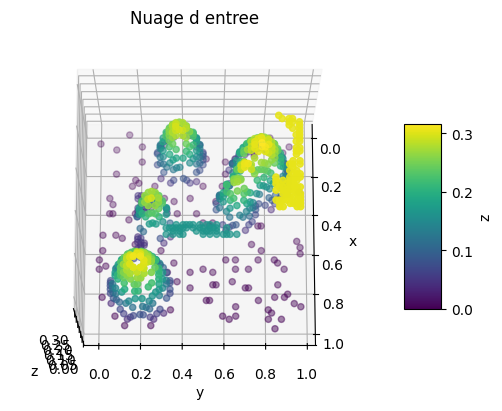

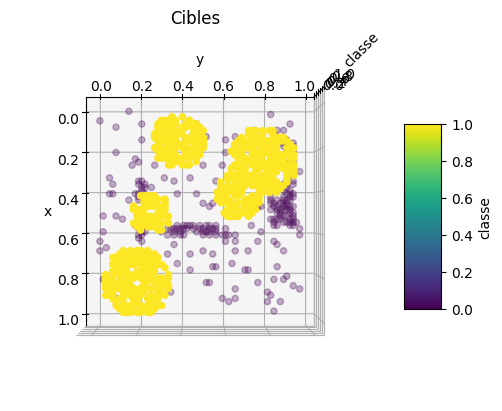

5


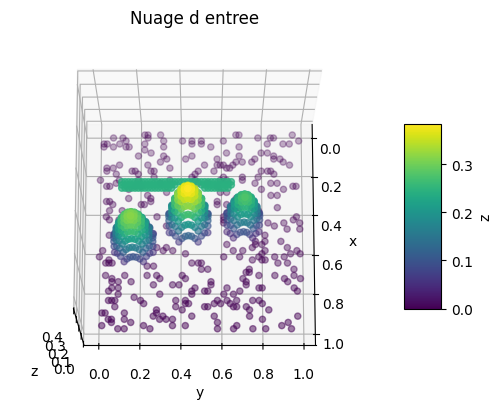

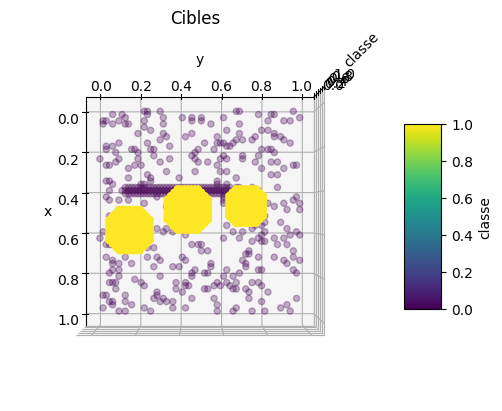

In [3]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [9]:

# Input_points is a tensor of shape (batch_size, 3, num_points)
#
# * batch_size : Number of point clouds in a batch.
# * 3 : Represents the x, y, and z coordinates of each point.
# * num_points :  The number of points in each point cloud.

input_points.shape

torch.Size([6, 3, 800])

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Les points d'un nuage ne sont pas rangés dans un ordre particulier.  L'ordre des points dans le tenseur input_points n'a pas de signification sémantique.  Ils peuvent être mélangés sans altérer l'information contenue dans le nuage de points.  Les algorithmes comme PointNet sont conçus pour être invariants à l'ordre des points d'entrée.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

In [ ]:
# Pour traiter le problème de segmentation de nuages de points avec un FCN ou un ViT, il faudrait adapter ces architectures initialement conçues pour les images à la structure des données 3D.

# **FCN (Fully Convolutional Network):**
# 1. **Représentation voxelisée:**  Transformer le nuage de points en une représentation voxelisée (grille 3D). Chaque voxel contiendrait une valeur représentant la présence ou l'absence d'un point, et potentiellement d'autres caractéristiques (densité locale, etc.).  La résolution de la grille serait un paramètre crucial. Une résolution trop fine serait coûteuse en calcul, une résolution trop grossière entraînerait une perte d'information.
# 2. **Application du FCN:** Appliquer un FCN standard à cette représentation voxelisée.  Le FCN serait entraîné à prédire une classe pour chaque voxel, puis on pourrait relier cette prédiction aux points du nuage de points d'origine.
# 3. **Avantages:**  Les FCN sont relativement simples à mettre en œuvre et peuvent être efficaces si la résolution de la grille est judicieusement choisie.
# 4. **Inconvénients:** La voxelisation peut introduire une perte d'information et une forte augmentation de la quantité de données à traiter, notamment lorsque la résolution est élevée.

# **ViT (Vision Transformer):**
# 1. **Construction de patchs:**  Définir des "patchs" dans l'espace 3D.  Contrairement aux images où les patchs sont des régions rectangulaires 2D, ici, les patchs pourraient être des volumes 3D ou des sous-ensembles de points voisins.
# 2. **Encodage des patchs:**  Encoder chaque patch en une représentation vectorielle.  On pourrait utiliser des méthodes d'encodage similaires à celles employées dans les ViT pour les images, mais adaptées à la structure 3D des données.
# 3. **Architecture du Transformer:**  Appliquer l'architecture Transformer standard (attention mechanism, etc.) à ces encodages de patchs.  L'architecture du Transformer permettrait de capturer les relations spatiales entre les différents patchs du nuage de points.
# 4. **Avantages:**  Le mécanisme d'attention permet aux ViT de traiter des données avec une structure non-euclidienne, comme les nuages de points. Ils peuvent capturer les relations à longue portée entre les points.
# 5. **Inconvénients:** Les ViT sont généralement plus complexes à mettre en œuvre et peuvent être plus gourmands en ressources que les FCN, surtout pour des données 3D à haute résolution.



## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [11]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

In [13]:


# According to the PointNet paper, the output of the network is a set of per-point features.
# The output tensor 'output' has dimensions (batch_size, num_points, num_classes).
#  - batch_size: The number of point clouds in the batch.
#  - num_points: The number of points in each point cloud.
#  - num_classes: The number of classes for segmentation (in this case, 2: igloo or not igloo).




# Create a random permutation of the points
perm = torch.randperm(input_points.size(2))
permuted_input = input_points[:, :, perm]

# Pass the permuted input through the network
permuted_output, _, _ = pointnet(permuted_input)

# Compare the output with the original output
# Due to the permutation invariance property of PointNet, the output should be the same.
# However, in practice due to floating point operations, this will be true only approximately.
# We can compare only few points as a proof of concept.

print("Original output (first 5 points):\n", output[0, :5, :])
print("\nPermuted output (first 5 points):\n", permuted_output[0, :5, :])
print("\nAre the outputs equal ?")
print(torch.allclose(output, permuted_output))

Original output (first 5 points):
 tensor([[-1.2054, -0.2444],
        [-1.1129, -0.0460],
        [-0.8235, -0.3449],
        [-0.5226, -0.4309],
        [-0.2294, -0.0767]], device='cuda:0', grad_fn=<SliceBackward0>)

Permuted output (first 5 points):
 tensor([[-1.0997, -0.0389],
        [-0.8429, -0.2752],
        [-0.1040, -0.6423],
        [-0.1778, -0.7732],
        [-0.3354, -0.6190]], device='cuda:0', grad_fn=<SliceBackward0>)

Are the outputs equal ?
False


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

In [ ]:


# Q2 Answer:
# Operations leading to segmentation (excluding Input Transform and Feature Transform):
# 1. Input Point Cloud: The input is a set of 3D points.
# 2. MLP (Multilayer Perceptron) Layers: A series of shared MLPs process each individual point.  "Shared" means that the same MLP weights and biases are used for each point in the point cloud.
# 3. Max Pooling: A max pooling operation aggregates the features from all points into a global feature vector. This operation is invariant to the point order, as the maximum feature value will be found regardless of its original position in the input.
# 4. Global Feature Concatenation: The global feature vector is concatenated with the individual point features (from step 2).  This provides each point with global context.
# 5. MLP (Multilayer Perceptron) Layers: Further shared MLPs process these combined point-wise and global features.
# 6. Output Layer (Segmentation): The final MLP generates a probability distribution over the classes for each point.


# Explanation of "shared" and permutation invariance:
# The term "shared" implies that the same set of weights and biases is applied to each individual point in the point cloud. This ensures that every point is processed by the same operations. This contributes to the invariance in the following ways:
# - Max pooling: As mentioned before, finding the maximum value of a set doesn't depend on the order in which the elements are presented.
# - MLP (Shared Weights):  Since each point is processed through the same set of MLP layers (with shared weights), the order in which the points are fed into the network doesn't affect the feature extraction. The feature vector for a specific point will always be the same regardless of the other points in the cloud.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [14]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

NameError: name 'PointNetSegLoss' is not defined

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10

for epoch in range(1, n_epochs + 1):
    print(f'Epoch {epoch}/{n_epochs}')

    for batch in range(1, n_batch_per_epoch + 1):
        input_points, target_list, target_points = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Propagation avant
        proba_pred_list, _, _ = pointnet(input_points)

        # Calcul de la perte
        proba_pred_list_transposed = proba_pred_list.transpose(1, 2)
        loss = loss_fn(proba_pred_list_transposed, target_list)

        # Rétropropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcul de la justesse (accuracy)
        pred_list = proba_pred_list_transposed.max(1)[1].cpu()
        accuracy = (pred_list == target_list.cpu()).float().mean()

        print(f'Batch {batch}/{n_batch_per_epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')


In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
